<a href="https://colab.research.google.com/github/Sergik1994/Telegram_bot/blob/main/08_04_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Фаза 2 • Неделя 8 • Четверг
## Нейронные сети
### 🔥 PyTorch: fine tuning

### Подготовка к работе

1. Загрузи этот ноутбук на Google Colab
2. Подгрузи архив [датасета](https://www.kaggle.com/datasets/ikobzev/architectural-heritage-elements-image64-dataset) в свое пространство и разархивируй его с помощью `unzip`.

In [16]:
!pip install torchutils

In [17]:
import zipfile
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.datasets import CIFAR10
from torchvision import transforms as T
from torch.nn import functional as F
import numpy as np
import torchutils as tu
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder


In [18]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun 20 17:01:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [20]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [24]:
from google.colab import drive
drive.flush_and_unmount()  # Размонтировать Google Drive
drive.mount('/content/drive')  # Снова смонтировать Google Drive

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [25]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [27]:
!ls "/content/drive/MyDrive/Colab_Notebooks"

08-04-task.ipynb  archive.zip  test  train


In [28]:
zip_path = "/content/drive/MyDrive/Colab_Notebooks/archive.zip"

In [30]:
# Укажите путь, куда вы хотите распаковать архив
extract_path = "/content/drive/MyDrive/Colab_Notebooks"

In [31]:
# Распаковка архива
!unzip -o {zip_path} -d {extract_path}

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/drive/MyDrive/Colab_Notebooks/train/dome(outer)/1294.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/train/dome(outer)/1295.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/train/dome(outer)/1296.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/train/dome(outer)/1297.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/train/dome(outer)/1298.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/train/dome(outer)/1299.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/train/dome(outer)/1300.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/train/dome(outer)/1301.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/train/dome(outer)/1302.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/train/dome(outer)/1303.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/train/dome(outer)/1304.jpg  
  inflating: /content/drive/MyDrive/Colab

1. Убедись, что структура папок соответствует задаче классификации (либо приведите ее к формату, указанному ниже):

        `train`
        
            - class_1
            - class_2
            - ...
            - class_n
            
        `valid`

            - class_1
            - class_2
            - ...
            - class_n

In [ ]:
# code

2. Создай `DataLoader` в для обучающей и валидационных выборок. Примените аугментации к изображениям.

In [32]:
train_loader = '/content/drive/MyDrive/Colab_Notebooks/train'
test_loader = '/content/drive/MyDrive/Colab_Notebooks/test'

In [33]:
# Преобразования изображений для нормализации
transform = transforms.Compose([
    transforms.ToTensor()  # Преобразование изображения в тензор
])

# Создание набора данных ImageFolder
dataset = ImageFolder(root=train_loader, transform=transform)

# Создание DataLoader для загрузки данных по батчам
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

# Переменные для хранения суммы и квадратной суммы пикселей для каждого канала
sum_channels = torch.zeros(3)
sum_squares_channels = torch.zeros(3)
total_images = len(dataset)

# Проход по всем изображениям в наборе данных
for images, _ in loader:
    # Разделение изображения на каналы RGB
    r_channel = images[:, 0, :, :]
    g_channel = images[:, 1, :, :]
    b_channel = images[:, 2, :, :]

    # Обновление суммы и квадратной суммы пикселей для каждого канала
    sum_channels[0] += torch.sum(r_channel)
    sum_channels[1] += torch.sum(g_channel)
    sum_channels[2] += torch.sum(b_channel)

    sum_squares_channels[0] += torch.sum(r_channel ** 2)
    sum_squares_channels[1] += torch.sum(g_channel ** 2)
    sum_squares_channels[2] += torch.sum(b_channel ** 2)

# Рассчет среднего значения и стандартного отклонения по каналам
mean = sum_channels / (total_images * images.size(2) * images.size(3))
std = torch.sqrt((sum_squares_channels / (total_images * images.size(2) * images.size(3))) - mean ** 2)

# Вывод результатов
print("Среднее значение по каналам (R, G, B):", mean)
print("Стандартное отклонение по каналам (R, G, B):", std)

Среднее значение по каналам (R, G, B): tensor([0.3702, 0.3136, 0.2569])
Стандартное отклонение по каналам (R, G, B): tensor([0.2288, 0.2174, 0.2160])


In [34]:
# Преобразования данных для трейн выборок
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(45),#  случайным образом поворачивает изображение на заданный угол -- аугментация
    T.RandomPerspective(),
    transforms.ToTensor(),
    transforms.Normalize((0.45, 0.42, 0.4), (0.25, 0.25, 0.3))
])

In [35]:
# Преобразования данных для тестовой выборок
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.45, 0.42, 0.4), (0.25, 0.25, 0.3))
])

In [36]:
train_dataset = datasets.ImageFolder(train_loader, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.ImageFolder(test_loader, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

3. Создай экземпляр предобученной модели: [torchvision models](https://pytorch.org/vision/stable/models.html). Можно взять любую модель для baseline, а дальше попробовать что-то более сложное.

In [41]:
from torchvision.models import regnet_y_400mf, RegNet_Y_400MF_Weights

# Создание модели с предобученными весами
model = regnet_y_400mf(weights=RegNet_Y_400MF_Weights.DEFAULT)

In [42]:
model.to(DEVICE)
tu.get_model_summary(model, torch.randn(64, 3, 224, 224, device=DEVICE))

Layer                                                                  Kernel              Output         Params            FLOPs
0_stem.Conv2d_0                                                      [3, 32, 3, 3]   [64, 32, 112, 112]       864     693,633,024
1_stem.BatchNorm2d_1                                                          [32]   [64, 32, 112, 112]        64     102,760,448
2_stem.ReLU_2                                                                    -   [64, 32, 112, 112]         0               0
3_trunk_output.block1.block1-0.proj.Conv2d_0                        [32, 48, 1, 1]     [64, 48, 56, 56]     1,536     308,281,344
4_trunk_output.block1.block1-0.proj.BatchNorm2d_1                             [48]     [64, 48, 56, 56]        96      38,535,168
5_trunk_output.block1.block1-0.f.a.Conv2d_0                         [32, 48, 1, 1]   [64, 48, 112, 112]     1,536   1,233,125,376
6_trunk_output.block1.block1-0.f.a.BatchNorm2d_1                              [48]   [64, 

5. Замени выходной слой форматом, который подходит под задачу: бинарная или многоклассовая классификация.

In [43]:
model.fc = nn.Linear(512, 10)

In [44]:
model

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=6, bias=False)
            

6. Обучи модель (только последний слой!) и зафиксируй метрику на валидационной части выборки.

In [45]:
model.to(DEVICE)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=6, bias=False)
            

In [46]:
# Проверяем, какие параметры обучаемые
for param in model.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [47]:
# «Замораживаем» параметры
for param in model.parameters():
    param.requires_grad = False
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [48]:
# «Размораживаем» те веса, которые будем
# обучать
model.to(DEVICE)
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

In [49]:
# «Замораживаем» параметры
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [50]:
class myRegNet(nn.Module):
    def __init__(self):
         super().__init__()
         self.model = regnet_y_400mf(weights=RegNet_Y_400MF_Weights.DEFAULT)
         self.model.fc = nn.Linear(440, 10)
         # замораживаем слои
         for i in self.model.parameters():
             i.requires_grad = False
        # размораживаем только последний, который будем обучать
         self.model.fc.weight.requires_grad = True
         self.model.fc.bias.requires_grad = True

    def forward(self, x):
        return self.model(x)



In [51]:
model = myRegNet()
model.to(DEVICE);

In [53]:
def check_labels(loader, num_classes):
    for batch_idx, (images, labels) in enumerate(loader):
        if labels.min().item() < 0 or labels.max().item() >= num_classes:
            print(f"Label out of range in batch {batch_idx}: {labels}")
            return False
    return True

num_classes = 10

# Проверка меток в train_loader
if check_labels(train_loader, num_classes):
    print("All labels in train_loader are within the valid range.")
else:
    print("Some labels in train_loader are out of range.")

# Проверка меток в valid_loader
if check_labels(test_loader, num_classes):
    print("All labels in valid_loader are within the valid range.")
else:
    print("Some labels in valid_loader are out of range.")

All labels in train_loader are within the valid range.
All labels in valid_loader are within the valid range.


In [54]:
from torchvision.models import resnet18, ResNet18_Weights

model_2 = resnet18(weights=ResNet18_Weights.DEFAULT)
model_2

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [55]:
class myResNet(nn.Module):
    def __init__(self):
         super().__init__()
         self.model =  resnet18(weights=ResNet18_Weights.DEFAULT)
         self.model.fc = nn.Linear(512, 10)
         # замораживаем слои
         for i in self.model.parameters():
             i.requires_grad = False
        # размораживаем только последний, который будем обучать
         self.model.fc.weight.requires_grad = True
         self.model.fc.bias.requires_grad = True

    def forward(self, x):
        return self.model(x)


In [56]:
model_2 = myResNet()
model_2.to(DEVICE);

In [57]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

In [59]:
train_epoch_acc = []
train_epoch_losses = []
valid_epoch_losses = []
valid_epoch_acc =[]
for epoch in range(6):
    model.train()
    loss_batch = []
    acc_batch  = []

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        preds = model(images).squeeze(-1)
        # print(preds, labels)

        loss = criterion(preds, labels)
        # print(loss.item())

        loss_batch.append(loss.item())
        accuracy = (preds.argmax(dim=1) == labels).float().mean().cpu().numpy()

       # accuracy = (preds.sigmoid().round() == labels).cpu().numpy().mean()
        acc_batch.append(accuracy)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_epoch_losses.append(np.mean(loss_batch))
    train_epoch_acc.append(np.mean(acc_batch))

    model.eval()
    loss_batch = []
    acc_batch  = []
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        preds = model(images).squeeze(-1)

        loss = criterion(preds, labels)
        loss_batch.append(loss.item())

        accuracy = (preds.argmax(dim=1) == labels).float().mean().cpu().numpy()

       # accuracy = (preds.sigmoid().round() == labels).cpu().numpy().mean()
        acc_batch.append(accuracy)

    valid_epoch_losses.append(np.mean(loss_batch))
    valid_epoch_acc.append(np.mean(acc_batch))

    print(f'Epoch: {epoch}  loss_train: {train_epoch_losses[-1]:.3f}, loss_valid: {valid_epoch_losses[-1]:.3f}')
    print(f'\t   metrics_train: {train_epoch_acc[-1]:.3f}, metrics_valid: {valid_epoch_acc[-1]:.3f}')

Epoch: 0  loss_train: 0.239, loss_valid: 5.363
	   metrics_train: 0.928, metrics_valid: 0.058
Epoch: 1  loss_train: 0.195, loss_valid: 7.026
	   metrics_train: 0.937, metrics_valid: 0.042
Epoch: 2  loss_train: 0.151, loss_valid: 7.338
	   metrics_train: 0.958, metrics_valid: 0.053
Epoch: 3  loss_train: 0.135, loss_valid: 7.416
	   metrics_train: 0.969, metrics_valid: 0.044
Epoch: 4  loss_train: 0.117, loss_valid: 7.399
	   metrics_train: 0.969, metrics_valid: 0.047
Epoch: 5  loss_train: 0.115, loss_valid: 7.486
	   metrics_train: 0.965, metrics_valid: 0.051


In [60]:
def check_weights(model):
    for name, param in model.named_parameters():
        if torch.isnan(param).any():
            print(f'NaN detected in {name}')
        if torch.isinf(param).any():
            print(f'Inf detected in {name}')

model = myRegNet()
check_weights(model)


7. Распечатай изображение из тестовой выборки и подпиши класс картинки, предсказанный моделью.

In [61]:
img, true_label = next(iter(test_loader))

In [62]:
print(img.shape)
print(true_label[0])

torch.Size([64, 3, 224, 224])
tensor(0)


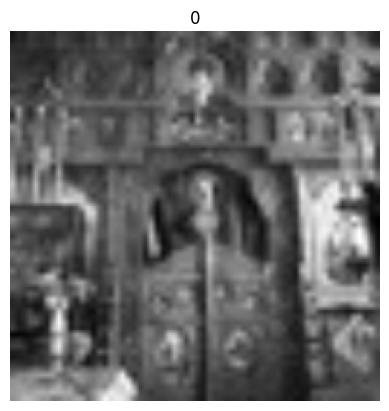

In [66]:
plt.imshow(img[0][0].cpu().numpy(), cmap='gray')
plt.title(f'{true_label[0]}'); plt.axis('off');

8. "Разморозь" несоклько слоев базовой модели и вновь обучи ее. Зафиксируй метрику качества для модели. О том, как сделать unfreeze нескольких слоев сразу, а не только последнего, можно почитать тут: [discuss.pytorch.org](https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/3)

In [ ]:
# code

9. Сравни качество двух моделей: предобученной с замененным выходным слоем и дообученной с несколькими размороженными слоями.

In [ ]:
# code

<img src="https://icons.iconarchive.com/icons/icons8/windows-8/256/Programming-Github-icon.png" width=32 /> Сохрани файл для __github__ и распечатай результат команды `!git status` в ячейке ниже.

10. Сохрани модель (пример можно посмотреть [тут](../../learning/aux/model_saving.ipynb) или в [документации](https://pytorch.org/tutorials/beginner/saving_loading_models.html))

In [68]:
torch.save(model, PATH)

NameError: name 'PATH' is not defined

11. Реализуй функцию, которая на вход принимает путь к файлу, а в ответ возвращает класс объекта.

In [ ]:
def get_prediction(path: str) -> str:
    pass

12. Сохрани ноутбук на github

13. Реализуй telegram-бот, которому пользователь присылает картинку, а бот возвращает пользователю класс объекта, котороый изображен на картинке.